In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
# import torch.autograd.Variable as Variable
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import time
import os
import copy
from pathlib import Path

from utils import trainer, helper_fn, data_setup

In [2]:
data_dir = './data/dataset/'
batch_size = 8


train_loader, val_loader, image_datasets = data_setup.load_split_train_val(data_dir, .2)

classes = (train_loader.dataset.classes)
print(classes)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['alien_test', 'cloudy', 'foggy', 'rainy', 'shine', 'sunrise']


In [3]:
# Create training and testing DataLoaders as well as get a list of class names
# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
#                                                                                test_dir=test_dir,
#                                                                                transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
#                                                                                batch_size=32) # set mini-batch size to 32

# train_dataloader, test_dataloader, class_names

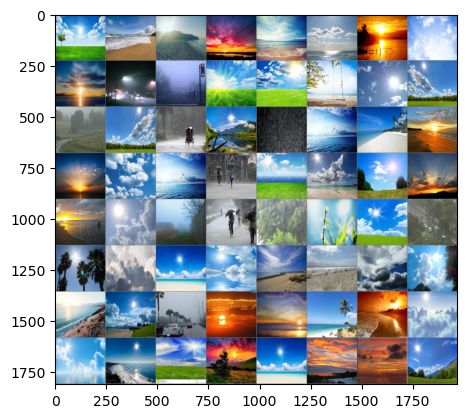

In [5]:
def imshow(img):
  
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = next(dataiter)  # dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
# print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 5 * 5)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [7]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) 
num_ftrs = model_ft.fc.in_features

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, len(train_loader.dataset.classes)))



criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

model_ft = model_ft.to(device)

In [8]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = trainer.train(model=model_ft,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer_ft,
                       loss_fn=criterion,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5000 | train_acc: 0.4625 | test_loss: 1.2265 | test_acc: 0.5728
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.7832 | test_loss: 0.8884 | test_acc: 0.7200
Epoch: 3 | train_loss: 0.5931 | train_acc: 0.8040 | test_loss: 0.7713 | test_acc: 0.6752
Epoch: 4 | train_loss: 0.4748 | train_acc: 0.8495 | test_loss: 0.5464 | test_acc: 0.8195
Epoch: 5 | train_loss: 0.3844 | train_acc: 0.9120 | test_loss: 0.5274 | test_acc: 0.8273
[INFO] Total training time: 423.102 seconds


In [9]:
torch.save(model_ft, './model/fake_model_test.pth')

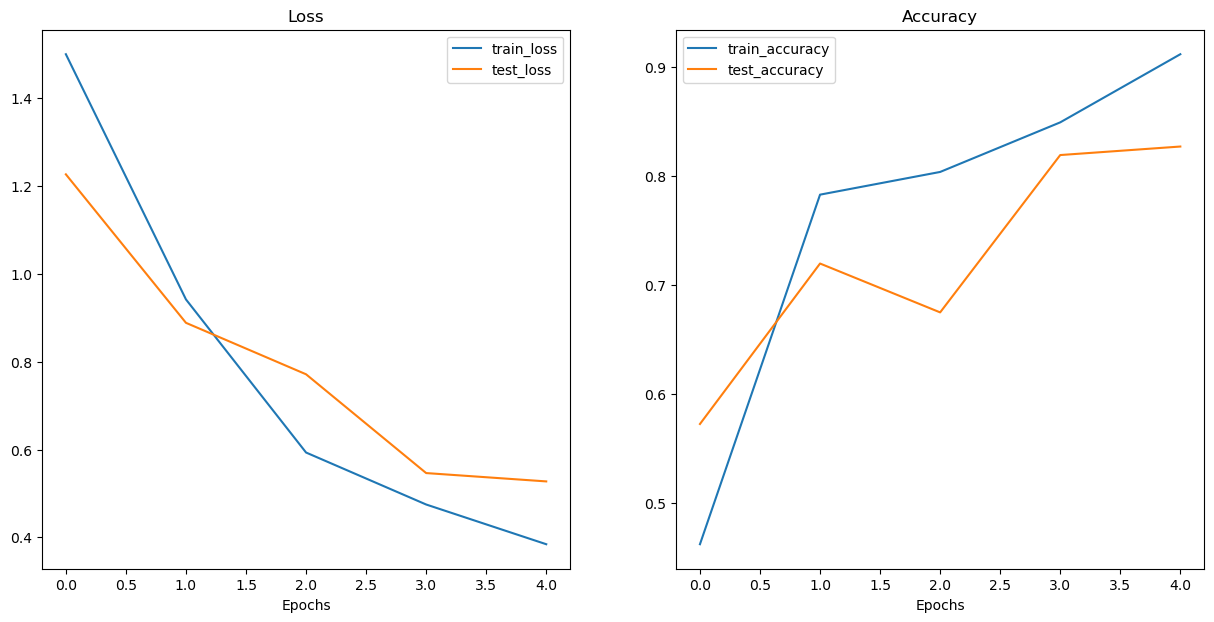

In [10]:
helper_fn.plot_loss_curves(results)

In [ ]:
transformations = transforms.Compose([
                    transforms.Resize([224, 244]),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

import random
test_dir = './data/test/'
num_images_to_plot = 6
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    helper_fn.pred_and_plot_image(model=model_ft, 
                        image_path=image_path,
                        class_names=classes,
                        transform=transformations, 
                        image_size=(224, 224))

In [11]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title(f'predicted: {class_names[preds[j]]}')
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [12]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

In [13]:
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)

# start.record()

# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# # whatever you are timing goes here
# # end.record()

# # # Waits for everything to finish running
# # torch.cuda.synchronize()

# print('Finished Training')
# # print(start.elapsed_time(end))  # milliseconds

In [14]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model